Évaluation des résultats de lemmatisation 
==================================

## Objectifs

1. Lecture des logs
2. Alignement avec types de modèles
3. Lectures des résultats

## Data acquisition

In [31]:
import glob
import copy
from pandas import DataFrame

# IMPORTANT: THIS IS HARD CODED, SUPPORT FOR ALL LEMMA FROM DEV SET

nb_words_dev_set = 40812


ModelScheme = {
    "config": "",
    "tar": "",
}
file = "./logs/single-tasks-lemma-try.log"

def parse_lines(lines, task_prefix="## ", is_file=True):
    models = []
    tasks = []
    config = None
    current_task = None
    template = {
        "scores": {},
        "eval-time": [],
        "optimizer": "adam"
    }
    current = copy.deepcopy(template)
    for line in lines:
        if is_file and line.startswith("config_path: "):
            current["config"] = line.strip()[len("config_path: "):]
        elif is_file and line.startswith("cemb_dim: "):
            current["cemb_dim"] = line.strip()[len("cemb_dim: "):]
        elif is_file and line.startswith("cell: "):
            current["cell"] = line.strip()[len("cell: "):]
        elif is_file and line.startswith("hidden_size: "):
            current["hidden_size"] = line.strip()[len("hidden_size: "):]
        elif is_file and line.startswith("optimizer: "):
            current["optimizer"] = line.strip()[len("optimizer: "):]
        elif is_file and "Bye" in line.strip():
            models.append(current)
            current = copy.deepcopy(template)
            current_task = None
        elif line.startswith(task_prefix):
            current_task = line.strip()[len(task_prefix):]
            tasks.append(current_task)
            current["scores"][current_task] = {}
            current["task"] = current_task
        elif current_task and line.startswith("|"):  # We already have a task recorded
            cat, acc, pre, rec, sup = [x.strip() for x in line.strip().split("|") if x]
            if sup == "support" or "---" in sup:
                continue
            current["scores"][current_task][cat] = (float(acc)*100, float(pre)*100, float(rec)*100, int(sup))
        elif is_file and ".tar" in line:
            current["file"] = line.strip()[len("Saved best model to: ["):-1]
        #elif is_file and "Finished training in " in line:
        #    current["training-time"] = float(line.strip()[len("2020-04-23 23:13:33,251 : Finished training in ["):-1])
        #elif is_file and "Starting epoch" in line:
        #    current["nb-epochs"] = int(line.strip()[len("2020-04-23 20:23:00,051 : Starting epoch ["):-1])
        #elif is_file and "Evaluation time: " in line:
        #    current["eval-time"].append(
        #        float(line.strip()[len("2020-04-24 04:04:56,425 : Evaluation time: "):-len(" sec")])
        #    )
    if not is_file:
        current["file"] = f"default-{len(models)}"
        models.append(current)
    models = {
        model.get("file", "default"): model for model in models
    }
    tasks = {
        task: [model for model in models.values() if model["task"] == task]
        for task in tasks
    }
    return models, tasks

with open(file) as f:
    models, tasks = parse_lines(f)

print(models)

{'./models/latin-upvc-single-lemma-complexe-lemma-2021_02_25-19_27_26.tar': {'scores': {'lemma': {'all': (94.78999999999999, 66.91, 65.68, 169819), 'known-tokens': (95.58, 74.27, 73.42999999999999, 161865), 'unknown-tokens': (78.83, 59.43000000000001, 58.60999999999999, 7954), 'ambiguous-tokens': (87.9, 52.790000000000006, 56.24, 42700), 'unknown-targets': (51.54, 34.599999999999994, 34.63, 1104)}}, 'eval-time': [], 'optimizer': 'Adam', 'cell': 'GRU', 'cemb_dim': '200', 'config': 'configs/single-tasks/lemma.json', 'hidden_size': '170', 'task': 'lemma', 'file': './models/latin-upvc-single-lemma-complexe-lemma-2021_02_25-19_27_26.tar'}, './models/latin-upvc-single-lemma-complexe-lemma-2021_02_25-21_09_16.tar': {'scores': {'lemma': {'all': (94.77, 67.03, 65.77, 169819), 'known-tokens': (95.62, 75.44999999999999, 74.7, 161865), 'unknown-tokens': (77.47, 57.18, 56.19, 7954), 'ambiguous-tokens': (88.0, 53.73, 56.82000000000001, 42700), 'unknown-targets': (49.370000000000005, 32.98, 32.83, 11

## Reference score

In [32]:
REF_NO_NOMPRO = """#### lemma

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9734   | 0.8216    | 0.8196 | 169822  |
| known-tokens     | 0.9785   | 0.907     | 0.907  | 161674  |
| unknown-tokens   | 0.8716   | 0.7172    | 0.7153 | 8148    |
| ambiguous-tokens | 0.9292   | 0.7114    | 0.7171 | 41561   |
| unknown-targets  | 0.4775   | 0.3136    | 0.3115 | 1131    |


#### pos

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9651   | 0.8794    | 0.8669 | 169822  |
| known-tokens     | 0.9672   | 0.8808    | 0.8703 | 161674  |
| unknown-tokens   | 0.9232   | 0.6979    | 0.6511 | 8148    |
| ambiguous-tokens | 0.91     | 0.8234    | 0.784  | 52129   |


#### Gend

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.965    | 0.9166    | 0.9203 | 169822  |
| known-tokens     | 0.9673   | 0.9198    | 0.9248 | 161674  |
| unknown-tokens   | 0.9201   | 0.8673    | 0.8543 | 8148    |
| ambiguous-tokens | 0.868    | 0.8652    | 0.8747 | 34690   |


#### Numb

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9719   | 0.9705    | 0.9697 | 169822  |
| known-tokens     | 0.9731   | 0.9716    | 0.9705 | 161674  |
| unknown-tokens   | 0.9482   | 0.9224    | 0.9358 | 8148    |
| ambiguous-tokens | 0.9042   | 0.9013    | 0.8979 | 38122   |


#### Case

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9219   | 0.8811    | 0.8177 | 169822  |
| known-tokens     | 0.9244   | 0.8865    | 0.8237 | 161674  |
| unknown-tokens   | 0.8719   | 0.6896    | 0.6738 | 8148    |
| ambiguous-tokens | 0.8296   | 0.8196    | 0.7667 | 63352   |


#### Deg

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9813   | 0.9694    | 0.971  | 169822  |
| known-tokens     | 0.9832   | 0.9711    | 0.9746 | 161674  |
| unknown-tokens   | 0.9434   | 0.9345    | 0.9149 | 8148    |
| ambiguous-tokens | 0.9186   | 0.906     | 0.9258 | 27870   |


#### Mood_Tense_Voice

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9831   | 0.7845    | 0.7355 | 169822  |
| known-tokens     | 0.9868   | 0.8039    | 0.7632 | 161674  |
| unknown-tokens   | 0.91     | 0.6172    | 0.5863 | 8148    |
| ambiguous-tokens | 0.924    | 0.6879    | 0.675  | 16963   |


#### Person

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9971   | 0.9875    | 0.9772 | 169822  |
| known-tokens     | 0.9978   | 0.989     | 0.9814 | 161674  |
| unknown-tokens   | 0.9834   | 0.9762    | 0.9536 | 8148    |
| ambiguous-tokens | 0.9768   | 0.9391    | 0.9068 | 10040   |


#### Dis

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9727   | 0.879     | 0.8797 | 169822  |
| known-tokens     | 0.9738   | 0.8803    | 0.8823 | 161674  |
| unknown-tokens   | 0.9519   | 0.6651    | 0.5761 | 8148    |
| ambiguous-tokens | 0.912    | 0.8603    | 0.8649 | 41821   |
""".split("\n")

REF = """
## lemma

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.972    | 0.82      | 0.8138 | 169819  |
| known-tokens     | 0.9768   | 0.8901    | 0.8878 | 161865  |
| unknown-tokens   | 0.8736   | 0.7299    | 0.7254 | 7954    |
| ambiguous-tokens | 0.9264   | 0.6885    | 0.6953 | 42700   |
| unknown-targets  | 0.6304   | 0.464     | 0.4619 | 1104    |


## pos

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9611   | 0.938     | 0.9271 | 169819  |
| known-tokens     | 0.9641   | 0.9462    | 0.9312 | 161865  |
| unknown-tokens   | 0.9017   | 0.6995    | 0.6657 | 7954    |
| ambiguous-tokens | 0.9031   | 0.8792    | 0.8432 | 52025   |


## Gend

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9631   | 0.9107    | 0.9138 | 169819  |
| known-tokens     | 0.9656   | 0.9145    | 0.9192 | 161865  |
| unknown-tokens   | 0.9125   | 0.8507    | 0.8357 | 7954    |
| ambiguous-tokens | 0.8796   | 0.8799    | 0.8891 | 40191   |


## Numb

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9718   | 0.9702    | 0.9698 | 169819  |
| known-tokens     | 0.9734   | 0.9717    | 0.9712 | 161865  |
| unknown-tokens   | 0.9395   | 0.9094    | 0.9196 | 7954    |
| ambiguous-tokens | 0.9086   | 0.9051    | 0.9019 | 39600   |


## Case

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9219   | 0.8863    | 0.8198 | 169819  |
| known-tokens     | 0.9243   | 0.8919    | 0.8262 | 161865  |
| unknown-tokens   | 0.8726   | 0.6355    | 0.6256 | 7954    |
| ambiguous-tokens | 0.8318   | 0.8454    | 0.7857 | 64272   |


## Deg

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9799   | 0.968     | 0.9703 | 169819  |
| known-tokens     | 0.9822   | 0.9702    | 0.9751 | 161865  |
| unknown-tokens   | 0.933    | 0.9246    | 0.8993 | 7954    |
| ambiguous-tokens | 0.9197   | 0.9188    | 0.9332 | 29785   |


## Mood_Tense_Voice

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9822   | 0.7717    | 0.6944 | 169819  |
| known-tokens     | 0.9857   | 0.7829    | 0.711  | 161865  |
| unknown-tokens   | 0.911    | 0.6222    | 0.5942 | 7954    |
| ambiguous-tokens | 0.9222   | 0.6828    | 0.6701 | 17876   |


## Person

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9971   | 0.9879    | 0.9768 | 169819  |
| known-tokens     | 0.9979   | 0.9893    | 0.9822 | 161865  |
| unknown-tokens   | 0.9821   | 0.976     | 0.9461 | 7954    |
| ambiguous-tokens | 0.9788   | 0.9416    | 0.9223 | 10188   |


## Dis

|                  | accuracy | precision | recall | support |
|------------------|----------|-----------|--------|---------|
| all              | 0.9716   | 0.8677    | 0.8749 | 169819  |
| known-tokens     | 0.973    | 0.8691    | 0.8783 | 161865  |
| unknown-tokens   | 0.9439   | 0.6508    | 0.5098 | 7954    |
| ambiguous-tokens | 0.9126   | 0.8507    | 0.8618 | 43148   |

""".split("\n")

ref, ref_tasks = parse_lines(REF, "## ", is_file=False)

## Tabulate data

In [46]:
column = [
    "file", "task", "config",
    "optimizer", "cell", "hidden", "cemb",
    "score",
    *[
        f"{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks["lemma"][0]["scores"]["lemma"]
        for score in ("acc", "prec", "rec")
    ],
    *[
        f"rank-{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks["lemma"][0]["scores"]["lemma"]
        for score in ("acc", "prec", "rec")
    ]
]

files = sorted(list(models.keys()))

table = []
for task, files in tasks.items():
    for model in files:
        table.append([
            model["file"],
            task,
            f'{model["optimizer"]}-{model["cell"]}-H{model["hidden_size"]}-C{model["cemb_dim"]}',
            model["optimizer"],
            model["cell"],
            model["hidden_size"],
            model["cemb_dim"],
            .0, # Future Ranking Score
            # Scores
            *[
                score
                for cat in tasks["lemma"][0]["scores"]["lemma"]
                for score in model["scores"][task].get(cat, [.0, .0, .0])[:3]
            ],
            *[
                .0
                for cat in tasks["lemma"][0]["scores"]["lemma"]
                for score in model["scores"][task].get(cat, [.0, .0, .0])[:3]
            ]
        ])
    
table = sorted(table, key=lambda x: f"{x[1]}.{x[8]*100:.2f}")  # 2 is acc, 3 amb, 5 tokens
table = [column] + table

In [47]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(table, floatfmt=":,2f", tablefmt='html')))

file,task,config,optimizer,cell,hidden,cemb,score,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec,rank-all-acc,rank-all-pre,rank-all-rec,rank-kno-tok-acc,rank-kno-tok-pre,rank-kno-tok-rec,rank-unk-tok-acc,rank-unk-tok-pre,rank-unk-tok-rec,rank-amb-tok-acc,rank-amb-tok-pre,rank-amb-tok-rec,rank-unk-tar-acc,rank-unk-tar-pre,rank-unk-tar-rec
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-10_27_08.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,89.99000000000001,45.28,42.089999999999996,91.34,50.05,47.03,62.470000000000006,40.54,38.6,85.16,37.75,40.739999999999995,42.84,27.389999999999997,27.33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-11_47_07.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,94.56,66.18,64.73,95.39,73.28,72.38,77.63,58.440000000000005,57.38999999999999,87.66000000000001,50.88,54.65,52.629999999999995,36.15,35.96,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_25-21_09_16.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,94.77,67.03,65.77,95.62,75.44999999999999,74.7,77.47,57.18,56.19,88.0,53.73,56.82000000000001,49.370000000000005,32.98,32.83,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_25-19_27_26.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,94.78999999999999,66.91,65.68,95.58,74.27,73.42999999999999,78.83,59.43000000000001,58.60999999999999,87.9,52.790000000000006,56.24,51.54,34.599999999999994,34.63,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-01_07_36.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,94.84,66.02,65.29,95.69,74.89,74.56,77.4,56.21000000000001,55.720000000000006,88.03999999999999,52.849999999999994,56.330000000000005,41.120000000000005,26.0,25.97,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-04_33_55.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,94.97,68.2,67.13,95.78,76.42,75.89,78.38000000000001,58.650000000000006,57.86,88.16000000000001,53.83,56.910000000000004,49.28,32.97,32.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-07_16_37.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,95.1,69.97,69.08,95.87,78.13,77.7,79.47,60.47,59.68,88.17,53.800000000000004,57.220000000000006,49.91,33.29,33.32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-02_32_22.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,95.48,71.45,70.75,96.17999999999999,79.82000000000001,79.49000000000001,81.23,62.03999999999999,61.53999999999999,88.61,55.47,58.75,48.28,31.919999999999998,31.830000000000002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe-lemma-2021_02_26-10_03_50.tar,lemma,Adam-GRU-H170-C200,Adam,GRU,170,200,0.0,95.65,73.25,72.64,96.34,81.69999999999999,81.5,81.62,63.160000000000004,62.67,88.94,57.78,60.480000000000004,49.0,32.4,32.37,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
./models/latin-upvc-single-lemma-complexe4-lemma-2021_02_28-08_41_32.tar,lemma,Adam-LSTM-H128-C300,Adam,LSTM,128,300,0.0,95.7,73.65,72.6,96.3,79.95,79.34,83.54,66.58,65.9,89.28,55.63,58.309999999999995,58.699999999999996,41.89,41.69,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
with open("3 - Optimisation des Modeles - Entrainement comme tache unique - Models - Full.csv", "w") as f:
    import csv
    writer = csv.writer(f)
    writer.writerows(table)

# Attempt at ranking

In [49]:
ranks = DataFrame(
    [x[1:] for x in table[1:]],
    columns=column[1:],
    index=[x[0] for x in table[1:]]
)
needs_ranking = column[8:column.index('rank-all-acc')]
    
for task in tasks:
    ranking_subset = needs_ranking if task == "lemma" else needs_ranking[:-3]
    for col in ranking_subset:
        #ranks[f"rank-{col}"] = ranks[col].rank(ascending=False)
        ranks[f"rank-{col}"] += ranks.where(ranks['task'].eq(task))[col].rank(ascending=False).fillna(0)

    #ranks["score"] = sum(
    #    ranks.where(ranks['task'].eq(task))[[f"rank-{col}" for col in needs_ranking]].fillna(0)
    #) / len(ranking_subset)

ranks["score"] += (sum([ranks[f"rank-{col}"].where(ranks['task'].eq("lemma")) for col in needs_ranking]) / (len(needs_ranking))).fillna(0)
ranks["score"] += (sum([ranks[f"rank-{col}"].where(ranks['task'].ne("lemma")) for col in needs_ranking]) / (len(needs_ranking)-3)).fillna(0)

ranks.to_csv("3 - Optimisation des Modeles - Entrainement comme tache unique - Models - Experiment Ranger Adams Hidden - Ranks.csv")

In [50]:
display(HTML(ranks.sort_values(["task", "score"]).to_html()))

,task,config,optimizer,cell,hidden,cemb,score,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec,rank-all-acc,rank-all-pre,rank-all-rec,rank-kno-tok-acc,rank-kno-tok-pre,rank-kno-tok-rec,rank-unk-tok-acc,rank-unk-tok-pre,rank-unk-tok-rec,rank-amb-tok-acc,rank-amb-tok-pre,rank-amb-tok-rec,rank-unk-tar-acc,rank-unk-tar-pre,rank-unk-tar-rec
./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,3.900000,97.32,84.41,84.09,97.72,90.53,90.52,89.23,76.31,75.96,92.56,69.62,70.30,62.05,45.10,44.96,2.5,1.0,1.0,4.0,3.0,3.5,1.0,1.0,1.0,4.0,4.0,4.0,8.5,10.0,10.0
./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-04_20_34.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,4.766667,97.32,83.82,83.41,97.75,90.46,90.41,88.58,75.11,74.65,92.73,69.97,70.58,61.96,45.14,45.01,2.5,2.0,2.0,3.0,5.0,5.0,5.0,5.0,5.0,3.0,3.0,3.0,10.0,9.0,9.0
./models/latin-upvc-single-lemma-complexe4-lemma-2021_02_28-02_08_11.tar,lemma,Adam-LSTM-H128-C300,Adam,LSTM,128,300,6.066667,97.22,83.53,83.27,97.63,89.95,90.00,88.70,75.28,74.95,92.32,67.38,68.48,63.13,46.43,46.36,6.0,3.0,4.0,10.0,9.0,8.0,3.0,2.0,2.0,10.0,13.0,12.0,3.0,3.0,3.0
./models/latin-upvc-single-lemma-complexe6-lemma-2021_03_01-16_01_19.tar,lemma,Ranger-LSTM-H128-C250,Ranger,LSTM,128,250,6.300000,97.25,83.39,82.98,97.68,89.86,89.83,88.61,75.15,74.72,92.52,67.85,68.78,62.41,45.74,45.54,5.0,5.0,6.0,6.5,11.0,12.0,4.0,4.0,4.0,5.0,9.0,9.0,4.0,5.0,5.0
./models/latin-upvc-single-lemma-complexe5-lemma-2021_02_28-20_18_34.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,8.933333,97.15,83.38,82.99,97.56,89.70,89.67,88.71,75.20,74.84,92.13,67.54,68.66,62.14,45.23,45.13,12.0,6.0,5.0,16.5,12.0,13.0,2.0,3.0,3.0,16.0,12.0,11.0,6.5,8.0,8.0
./models/latin-upvc-single-lemma-complexe4-lemma-2021_02_27-20_37_16.tar,lemma,Adam-LSTM-H128-C300,Adam,LSTM,128,300,11.000000,97.13,82.18,81.76,97.57,88.53,88.51,88.19,74.55,74.08,92.34,67.23,68.34,63.50,46.94,46.80,13.5,17.0,17.0,14.5,21.0,21.0,7.0,6.0,7.0,9.0,15.0,14.0,1.0,1.0,1.0
./models/latin-upvc-single-lemma-complexe5-lemma-2021_02_28-16_51_43.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,11.200000,97.34,83.46,83.32,97.83,91.43,91.41,87.31,72.55,72.53,92.94,71.75,72.17,49.73,33.31,33.25,1.0,4.0,3.0,1.0,1.0,1.0,19.0,21.0,19.0,1.0,1.0,1.0,32.0,31.0,32.0
./models/latin-upvc-single-lemma-complexe6-lemma-2021_03_01-09_29_50.tar,lemma,Ranger-LSTM-H128-C250,Ranger,LSTM,128,250,11.500000,97.31,83.21,82.95,97.80,90.98,90.96,87.38,72.83,72.64,92.86,70.80,71.10,50.63,34.28,33.97,4.0,7.0,7.5,2.0,2.0,2.0,18.0,18.0,17.0,2.0,2.0,2.0,30.0,29.0,30.0
./models/latin-upvc-single-lemma-complexe5-lemma-2021_02_28-14_22_55.tar,lemma,Ranger-LSTM-H128-C300,Ranger,LSTM,128,300,11.633333,97.16,82.95,82.57,97.60,89.69,89.66,88.13,74.34,73.99,92.22,68.14,68.90,60.42,43.74,43.57,11.0,9.0,9.0,11.5,13.0,14.0,8.0,8.5,8.0,15.0,8.0,8.0,17.5,17.0,17.0
./models/latin-upvc-single-lemma-complexe6-lemma-2021_03_01-14_21_45.tar,lemma,Ranger-LSTM-H128-C250,Ranger,LSTM,128,250,12.566667,97.13,82.42,82.04,97.58,89.12,89.11,87.99,73.86,73.52,92.28,67.63,68.72,61.68,44.58,44.44,13.5,12.0,13.0,13.0,17.0,17.0,11.0,11.0,11.0,12.0,11.0,10.0,11.0,13.0,13.0


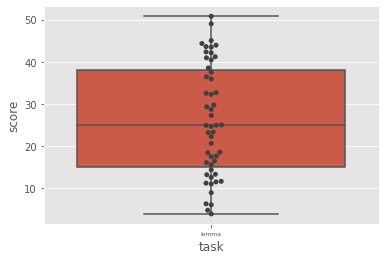

In [51]:
import seaborn as sns


ax = sns.boxplot(y="score", x="task", data=ranks)
ax = sns.swarmplot(y="score", x="task", data=ranks, color=".25")

# Evaluating against current best-model

In [39]:
ref_score = {
    task: tuple([
            score
            for cat in model["scores"][task]
            for score in model["scores"][task][cat][:3]
        ]
    )
    for model in ref.values()
    for task in model["scores"]
}

In [40]:
for task in tasks:
    need_diff = column[8:column.index('rank-all-acc')]
    need_diff = need_diff if task == "lemma" else need_diff[:-3]
    
    cols = [
        f"{'-'.join([x[:3] for x in cat.split('-')])}-{score[:3]}"
        for cat in tasks[task][0]["scores"][task]
        for score in ("acc", "prec", "rec")
    ]
    for cat, r in zip(cols, ref_score[task]):
        if f"diff-{cat}" not in ranks.columns:
            ranks[f"diff-{cat}"] = 0
        ranks[f"diff-{cat}"] += (ranks[cat].where(ranks['task'].eq(task)) - r).fillna(0)

# Evaluating (un)stability

<ipython-input-41-dc8950b07c54>:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


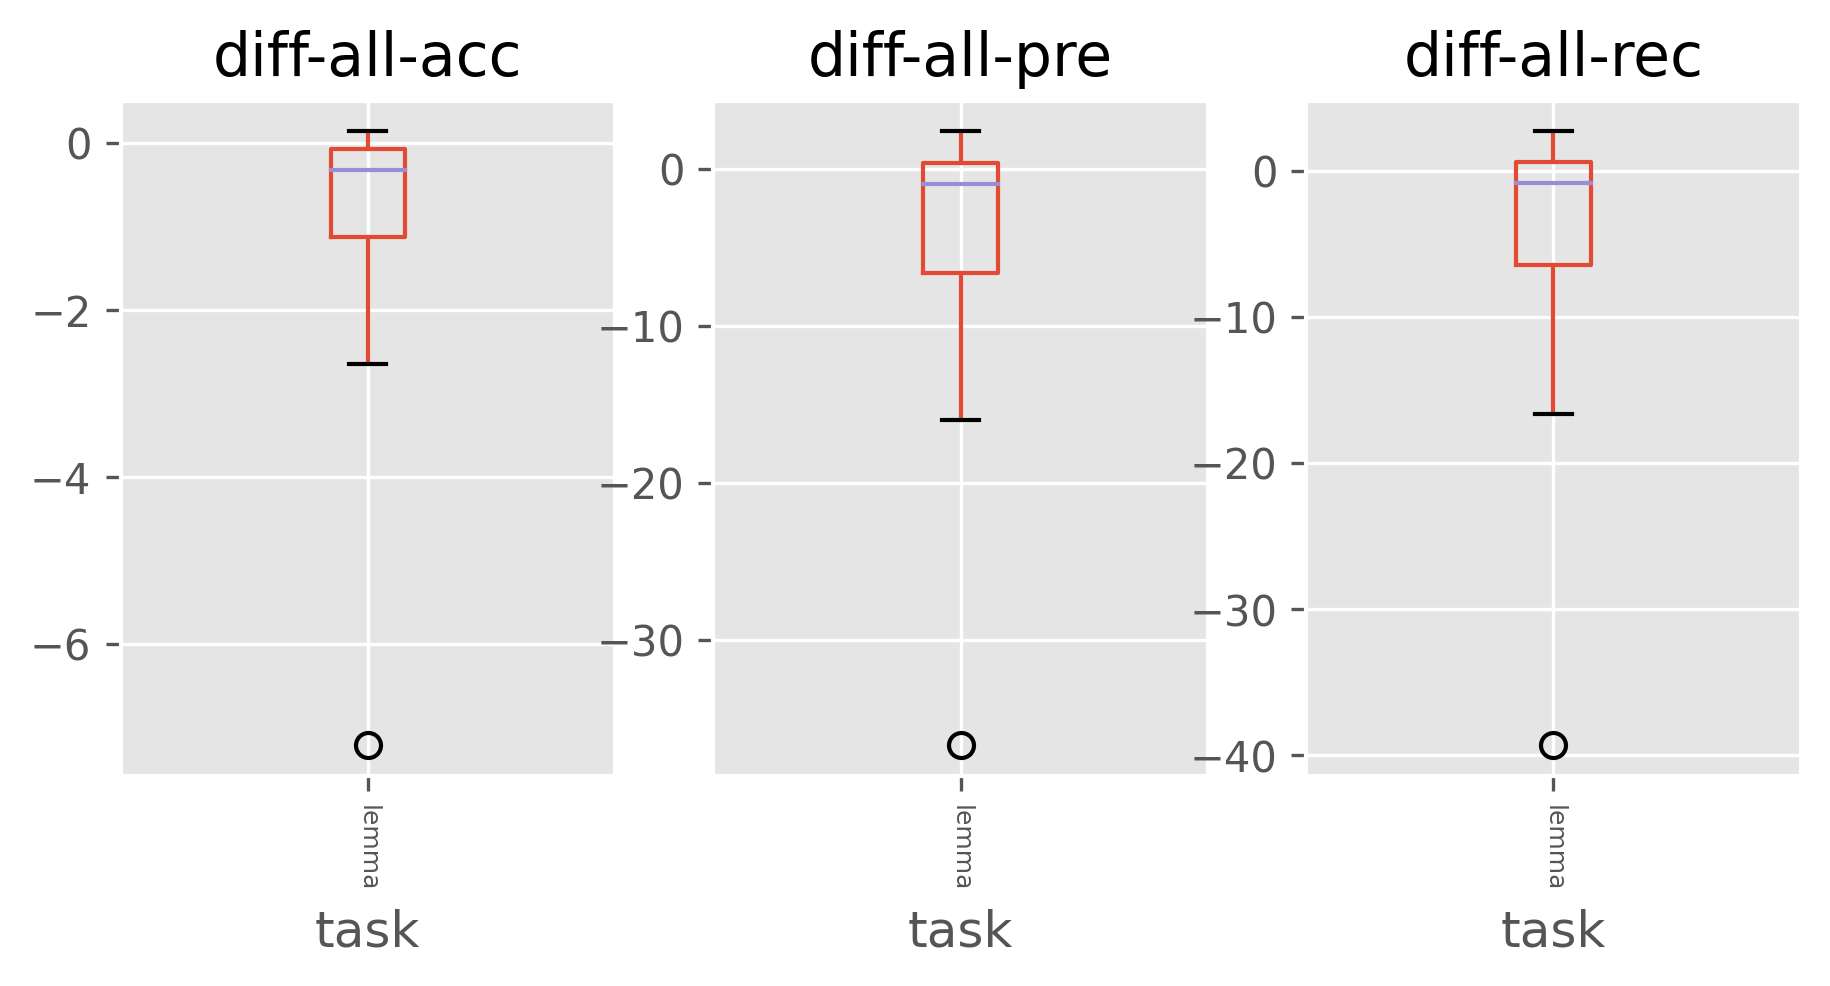

In [41]:
import matplotlib.pyplot as plt    

plt.style.use('ggplot')
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7,3), dpi=300)#, sharey=True)
ranks.boxplot(column="diff-all-acc", by="task", ax=ax1, vert=True, rot=-90)
ranks.boxplot(column="diff-all-pre", by="task", ax=ax2, vert=True, rot=-90)
ranks.boxplot(column="diff-all-rec", by="task", ax=ax3, vert=True, rot=-90)
fig.suptitle("")
fig.show()

<ipython-input-42-7ea1968d5674>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


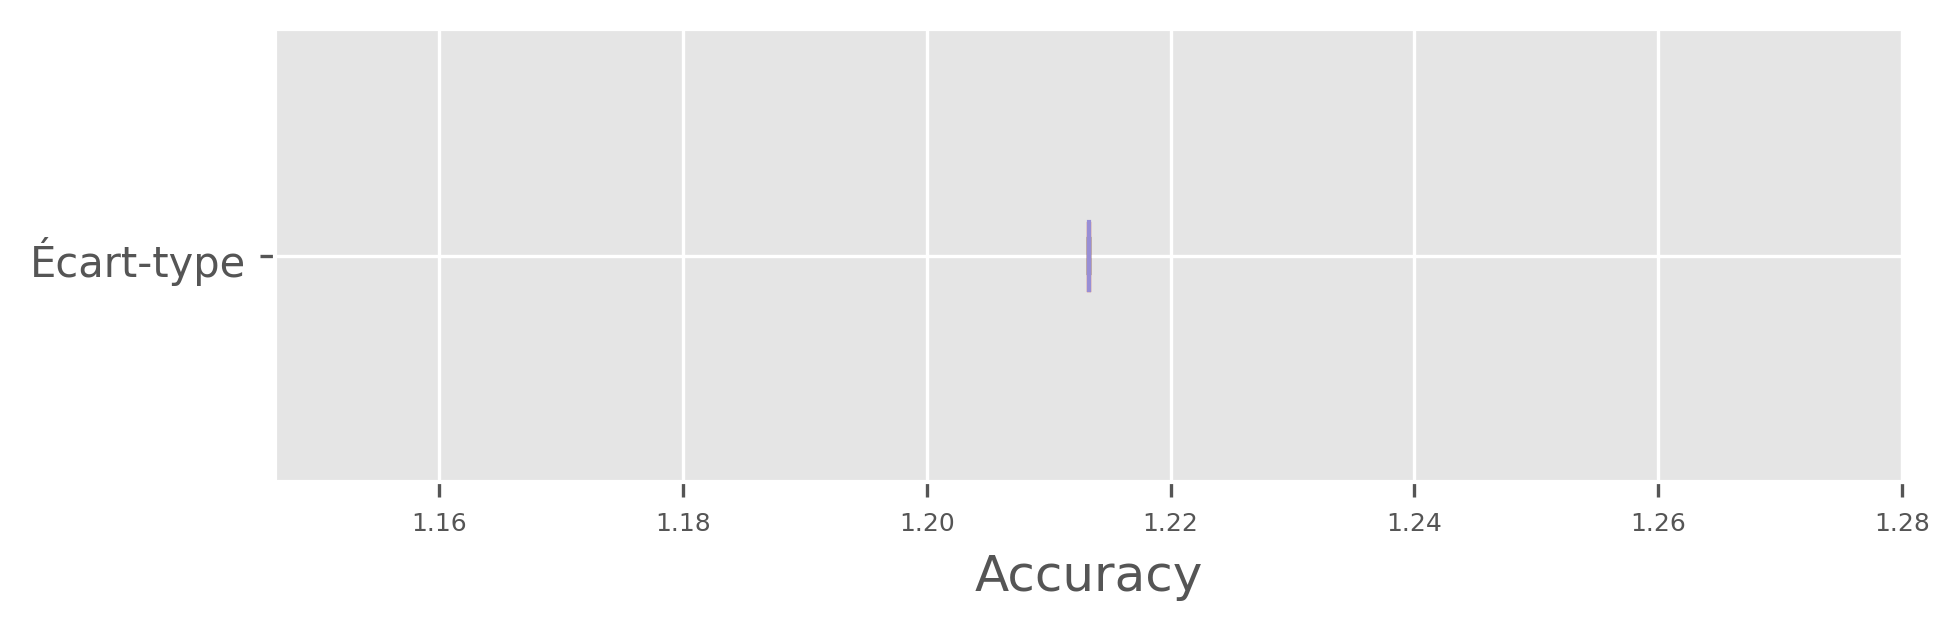

In [42]:
from pandas import Series

fig = plt.figure(figsize=(7,2), dpi=300)
ax = fig.gca()
serie = Series((ranks.groupby("task")["all-acc"].std()).tolist(), name="Écart-type")
ax = serie.plot.box(ax=ax, vert=False)#*100
ax.set_xlabel("Accuracy")
fig.show()

# Keeping the best model only

In [43]:
best = {
}

end_index = column.index('rank-all-acc')
elements = [
    ["file", "task"] + column[8:end_index]
]

for task in tasks:
    best_score = ranks.loc[ranks.task==task, "score"].min()
    print(best_score)
    
    best[task] = ranks.loc[ranks.task==task][ranks["score"]==best_score].index.tolist()[0]
    print(best[task])
    elements.append([
        best[task],
        task,
        *ranks[ranks.index==best[task]][(f"diff-{col}" for col in column[8:end_index])].values.tolist()[0]
    ])

3.9
./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar


In [44]:
# Create a table like representation
import tabulate
from IPython.display import HTML, display

display(HTML(tabulate.tabulate(elements, tablefmt='html')))

for task_row in elements[1:]:
    print(f"mv {task_row[0]} bests/{task_row[1]}.tar")

file,task,all-acc,all-pre,all-rec,kno-tok-acc,kno-tok-pre,kno-tok-rec,unk-tok-acc,unk-tok-pre,unk-tok-rec,amb-tok-acc,amb-tok-pre,amb-tok-rec,unk-tar-acc,unk-tar-pre,unk-tar-rec
./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar,lemma,0.11999999999999034,2.4099999999999966,2.710000000000008,0.03999999999999204,1.519999999999996,1.7399999999999949,1.8700000000000045,3.3200000000000074,3.4200000000000017,-0.0799999999999983,0.7700000000000102,0.769999999999996,-0.9899999999999949,-1.3000000000000043,-1.2299999999999969


mv ./models/latin-upvc-single-lemma-complexe5-lemma-2021_03_01-00_30_57.tar bests/lemma.tar


## Comparing Configurations

In [52]:
reformated = [[row[1], *row[2:5], row[5], row[8], row[11]] for row in elements]
print(tabulate.tabulate(
    reformated[1:], headers=reformated[0], tablefmt='github'))
print("-------------------------------------------------------")
print("-------------------------------------------------------")
print(ranks.filter(items=list(best.values()), axis=0)[reformated[0]].to_markdown(index=False))

| task   |   all-acc |   all-pre |   all-rec |   kno-tok-acc |   unk-tok-acc |   amb-tok-acc |
|--------|-----------|-----------|-----------|---------------|---------------|---------------|
| lemma  |      0.12 |      2.41 |      2.71 |          0.04 |          1.87 |         -0.08 |
-------------------------------------------------------
-------------------------------------------------------
| task   |   all-acc |   all-pre |   all-rec |   kno-tok-acc |   unk-tok-acc |   amb-tok-acc |
|:-------|----------:|----------:|----------:|--------------:|--------------:|--------------:|
| lemma  |     97.32 |     84.41 |     84.09 |         97.72 |         89.23 |         92.56 |
